<a href="https://colab.research.google.com/github/Bayzid03/LangGraph-Hub/blob/main/Customer%20Support%20Agent/Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Still working on this project

Smart Customer Support Agent

In [ ]:
!pip install langgraph langchain-google-genai python-dotenv

In [2]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv

In [3]:
from google.colab import userdata

# Explicitly get the API key from Colab secrets
api_key = userdata.get('GEMINI_API_KEY')

# Pass the API key to the ChatGoogleGenerativeAI model
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20", temperature=0.7, google_api_key=api_key)

Defining Agent State and Prompts

In [4]:
class SupportAgentState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    user_query: str
    query_category: str
    solution: str
    statisfaction_rating: int
    follow_up_needed: bool
    support_history: List[str]

query_analysis_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a customer support query analyzer. Analyze the customer query and categorize it into ONE of these categories:

Categories:
- technical: Software bugs, login issues, app crashes, feature problems, connectivity issues
- billing: Payment problems, subscription issues, refunds, charges, account billing
- general: Basic questions, account information, how-to guides, product information
- escalate: Complex issues, angry customers, legal matters, or anything requiring human intervention

Return ONLY the category name (technical/billing/general/escalate) without explanation."""),
    ("human", "Customer Query: {query}"),
])

technical_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a technical support specialist. Provide clear, step-by-step solutions for technical issues.

Format your response as:
**Problem Diagnosed:** [Brief description]
**Solution Steps:**
1. [Step 1]
2. [Step 2]
3. [Step 3]
**Additional Help:** [Any extra tips or resources]

Keep solutions practical and easy to follow."""),
    ("human", "Technical Issue: {query}"),
])

billing_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a billing support specialist. Help customers with payment and subscription issues.

Format your response as:
**Issue Summary:** [Brief description]
**Resolution Steps:**
1. [Step 1]
2. [Step 2]
3. [Step 3]
**Next Steps:** [What happens next or follow-up needed]

Be empathetic and provide clear billing information."""),
    ("human", "Billing Issue: {query}"),
])

general_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a friendly customer service representative. Provide helpful information for general inquiries.

Format your response as:
**Answer:** [Direct answer to their question]
**Additional Information:** [Helpful related details]
**Resources:** [Where they can find more help]

Be friendly, helpful, and informative."""),
    ("human", "Customer Question: {query}"),
])

escalation_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a customer service manager handling escalated issues. Be professional, empathetic, and assuring.

Format your response as:
**Acknowledgment:** [Acknowledge their concern]
**Next Steps:** [What will happen next]
**Timeline:** [When they can expect follow-up]
**Contact Information:** [How they can reach human support]

Show that their issue is being taken seriously."""),
    ("human", "Escalated Issue: {query}"),
])

satisfaction_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are evaluating customer satisfaction. Based on the solution provided and the original query, rate the likely satisfaction level from 1-5:

1 = Very Unsatisfied (complex issue, solution unclear)
2 = Unsatisfied (solution partially addresses issue)
3 = Neutral (solution is okay but could be better)
4 = Satisfied (good solution, addresses main concerns)
5 = Very Satisfied (excellent solution, comprehensive help)

Return ONLY the number (1-5) without explanation."""),
    ("human", "Original Query: {query}\n\nSolution Provided: {solution}"),
])

Define Agent **Functions**

In [5]:
def input_query(state: SupportAgentState) -> SupportAgentState:
    """Collect customer's support query"""
    print("=== Welcome to Smart Customer Support ===")
    print("Please describe your issue or question:")
    user_message = input("Your query: ")

    return {
        **state,
        "user_query": user_message,
        "messages": state.get('messages', []) + [HumanMessage(content=user_message)],
        "support_history": state.get('support_history', []) + [f"Query: {user_message}"]
    }

def analyze_query(state: SupportAgentState) -> SupportAgentState:
    """Analyze and categorize the customer query using LLM"""
    print("🔍 Analyzing your query...")

    # Use LLM to categorize the query
    response = llm.invoke(query_analysis_prompt.format_messages(query=state['user_query']))
    category = response.content.strip().lower()

    print(f"📋 Query categorized as: {category.upper()}")
    print("🔄 Routing to appropriate support specialist...\n")

    return {
        **state,
        "query_category": category,
        "messages": state.get('messages', []) + [AIMessage(content=f"Category: {category}")],
        "support_history": state.get('support_history', []) + [f"Categorized as: {category}"]
    }

def technical_support(state: SupportAgentState) -> SupportAgentState:
    """Handle technical support issues"""
    print("🔧 Technical Support Specialist")
    print("=====================================")

    response = llm.invoke(technical_prompt.format_messages(query=state['user_query']))
    solution = response.content

    print(solution)
    print("\n" + "="*50 + "\n")

    return {
        **state,
        "solution": solution,
        "messages": state.get('messages', []) + [AIMessage(content=solution)],
        "support_history": state.get('support_history', []) + ["Technical solution provided"]
    }

def billing_support(state: SupportAgentState) -> SupportAgentState:
    """Handle billing and payment issues"""
    print("💳 Billing Support Specialist")
    print("===============================")

    response = llm.invoke(billing_prompt.format_messages(query=state['user_query']))
    solution = response.content

    print(solution)
    print("\n" + "="*50 + "\n")

    return {
        **state,
        "solution": solution,
        "messages": state.get('messages', []) + [AIMessage(content=solution)],
        "support_history": state.get('support_history', []) + ["Billing solution provided"]
    }

def general_support(state: SupportAgentState) -> SupportAgentState:
    """Handle general questions and inquiries"""
    print("ℹ️  General Support Specialist")
    print("===============================")

    response = llm.invoke(general_prompt.format_messages(query=state['user_query']))
    solution = response.content

    print(solution)
    print("\n" + "="*50 + "\n")

    return {
        **state,
        "solution": solution,
        "messages": state.get('messages', []) + [AIMessage(content=solution)],
        "support_history": state.get('support_history', []) + ["General inquiry answered"]
    }

def escalate_to_human(state: SupportAgentState) -> SupportAgentState:
    """Escalate complex issues to human agents"""
    print("🚨 Escalating to Human Agent")
    print("==============================")

    response = llm.invoke(escalation_prompt.format_messages(query=state['user_query']))
    solution = response.content

    print(solution)
    print("\n" + "="*50 + "\n")

    return {
        **state,
        "solution": solution,
        "messages": state.get('messages', []) + [AIMessage(content=solution)],
        "support_history": state.get('support_history', []) + ["Escalated to human agent"]
    }

def check_satisfaction(state: SupportAgentState) -> SupportAgentState:
    """Evaluate customer satisfaction with the provided solution"""
    print("📊 Evaluating solution effectiveness...")

    # I used LLM to predict satisfaction score
    response = llm.invoke(satisfaction_prompt.format_messages(
        query=state['user_query'],
        solution=state['solution']
    ))

    try:
        satisfaction = int(response.content.strip())
    except:
        satisfaction = 3  # Default to neutral if parsing fails

    print(f"📈 Predicted satisfaction score: {satisfaction}/5")

    return {
        **state,
        "satisfaction_score": satisfaction,
        "support_history": state.get('support_history', []) + [f"Satisfaction: {satisfaction}/5"]
    }

def follow_up_required(state: SupportAgentState) -> SupportAgentState:
    """Handle cases where follow-up is needed due to low satisfaction"""
    print("📞 Follow-up Required")
    print("=====================")
    print("We noticed you might need additional assistance.")
    print("A senior support specialist will contact you within 24 hours.")
    print("Reference ID: SUP-" + str(hash(state['user_query']))[-6:])
    print("\nThank you for your patience!")

    return {
        **state,
        "follow_up_needed": True,
        "support_history": state.get('support_history', []) + ["Follow-up scheduled"]
    }

# Conditional Edge Functions (Router Logic)

def route_query(state: SupportAgentState) -> str:
    """Route queries to appropriate support specialist based on category"""
    category = state["query_category"].lower()

    # Decision logic for routing
    if "technical" in category or "bug" in category:
        return "technical_support"
    elif "billing" in category or "payment" in category:
        return "billing_support"
    elif "escalate" in category:
        return "escalate_to_human"
    else:
        return "general_support"

def route_satisfaction(state: SupportAgentState) -> str:
    """Route based on satisfaction score - low scores need follow-up"""
    if state["satisfaction_score"] < 3:
        return "follow_up_required"
    else:
        return END

Create and Compile the Graph

In [6]:
workflow = StateGraph(SupportAgentState)

# Add all nodes to the workflow
workflow.add_node("input_query", input_query)
workflow.add_node("analyze_query", analyze_query)
workflow.add_node("technical_support", technical_support)
workflow.add_node("billing_support", billing_support)
workflow.add_node("general_support", general_support)
workflow.add_node("escalate_to_human", escalate_to_human)
workflow.add_node("check_satisfaction", check_satisfaction)
workflow.add_node("follow_up_required", follow_up_required)

# Set entry point
workflow.set_entry_point("input_query")

# Add regular edges
workflow.add_edge("input_query", "analyze_query")

# Add conditional edges (this is the key new concept!)
workflow.add_conditional_edges(
    "analyze_query",  # From this node
    route_query,      # Use this function to decide
    {
        "technical_support": "technical_support",
        "billing_support": "billing_support",
        "general_support": "general_support",
        "escalate_to_human": "escalate_to_human"
    }
)

# All support paths lead to satisfaction check
workflow.add_edge("technical_support", "check_satisfaction")
workflow.add_edge("billing_support", "check_satisfaction")
workflow.add_edge("general_support", "check_satisfaction")
workflow.add_edge("escalate_to_human", "check_satisfaction")

# Conditional edge based on satisfaction
workflow.add_conditional_edges(
    "check_satisfaction",
    route_satisfaction,
    {
        "follow_up_required": "follow_up_required",
        END: END
    }
)

# Follow-up ends the workflow
workflow.add_edge("follow_up_required", END)

# Compile the workflow
app = workflow.compile()

🎯 Customer Support Agent Workflow:


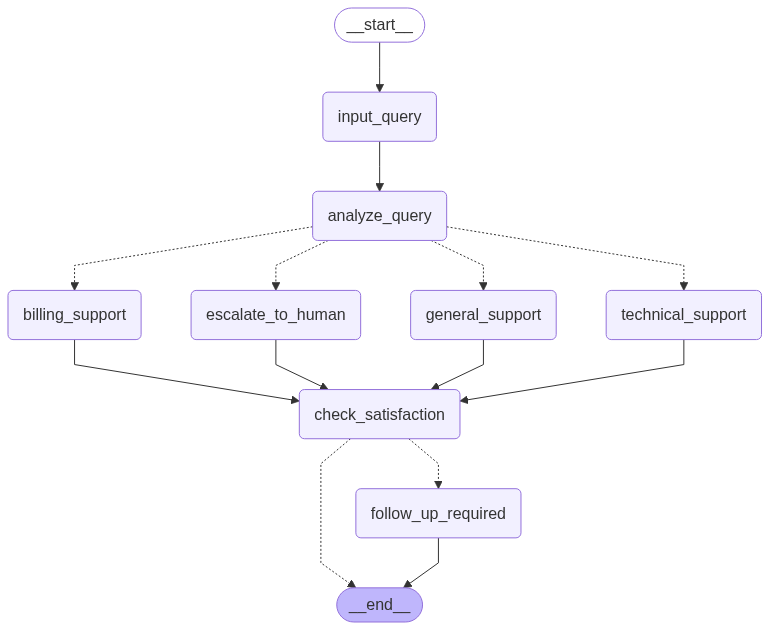

In [7]:
# Display the graph structure
print("🎯 Customer Support Agent Workflow:")
display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

In [9]:
# Main function to run the support agent
def run_support_agent(user_request: str):
    """Run the complete customer support workflow"""
    print(f"🎯 Support Request: {user_request}\n")

    # Initialize state
    state = {
        "messages": [HumanMessage(content=user_request)],
        "user_query": user_request, # Initialize user_query with the request
        "query_category": "",
        "solution": "",
        "satisfaction_score": 0, # Initialize satisfaction_score
        "follow_up_needed": False,
        "support_history": []
    }

    # Run the workflow
    # We iterate through the stream to ensure all nodes are executed
    for output in app.stream(state, {"recursion_limit": 100}):
        pass  # All printing is handled in the nodes

    print("\n🎊 Support session completed!")
    print("💬 We hope we were able to help you today!")

# Example usage
if __name__ == "__main__":
    user_request = "I need help with a customer service issue."
    run_support_agent(user_request)

🎯 Support Request: I need help with a customer service issue.

=== Welcome to Smart Customer Support ===
Please describe your issue or question:
Your query: "I was charged twice for my subscription.", "How do I update my payment information?", "I'd like a refund for a recent purchase.
🔍 Analyzing your query...
📋 Query categorized as: BILLING
🔄 Routing to appropriate support specialist...

💳 Billing Support Specialist
It sounds like you're experiencing a few different billing concerns, and I'm here to help clarify and resolve each one for you.

***

**Issue Summary:** Duplicate charge for subscription.
**Resolution Steps:**
1.  I understand how frustrating it can be to see a duplicate charge. To investigate this, please provide your account email address or username, and if possible, the transaction IDs or dates of the two charges.
2.  Once I have this information, I will verify the charges in our system.
3.  If a duplicate charge is confirmed, I will immediately process a refund for th

KeyError: 'satisfaction_score'

In [10]:
# Main function to run the support agent
def run_support_agent(user_request: str):
    """Run the complete customer support workflow"""
    print(f"🎯 Support Request: {user_request}\n")

    # Initialize state
    state = {
        "messages": [HumanMessage(content=user_request)],
        "user_query": user_request, # Initialize user_query with the request
        "query_category": "",
        "solution": "",
        "satisfaction_score": 0, # Initialize satisfaction_score
        "follow_up_needed": False,
        "support_history": []
    }

    # Run the workflow
    # We iterate through the stream to ensure all nodes are executed
    for output in app.stream(state, {"recursion_limit": 100}):
        pass  # All printing is handled in the nodes

    print("\n🎊 Support session completed!")
    print("💬 We hope we were able to help you today!")

# Example usage
if __name__ == "__main__":
    user_request = "I need help with a customer service issue."
    run_support_agent(user_request)

🎯 Support Request: I need help with a customer service issue.

=== Welcome to Smart Customer Support ===
Please describe your issue or question:
Your query: My app keeps crashing when I try to log in.", "How do I reset my password?", "The website isn't loading correctly on my browser.
🔍 Analyzing your query...
📋 Query categorized as: TECHNICAL
🔄 Routing to appropriate support specialist...

🔧 Technical Support Specialist
Here are the solutions for the technical issues you're experiencing:

---

**Problem Diagnosed:** App crashing during login attempt.
**Solution Steps:**
1.  **Restart the App:** Fully close the app (swipe it away from recent apps) and then open it again.
2.  **Restart Your Device:** Turn your smartphone or tablet completely off, wait 30 seconds, and then turn it back on.
3.  **Check for App Updates:** Go to your device's app store (Google Play Store for Android, App Store for iOS) and see if there's an update available for the app. Install it if there is.
4.  **Clear A

KeyError: 'satisfaction_score'

In [11]:
# Main function to run the support agent
def run_support_agent(user_request: str):
    """Run the complete customer support workflow"""
    print(f"🎯 Support Request: {user_request}\n")

    # Initialize state
    state = {
        "messages": [HumanMessage(content=user_request)],
        "user_query": user_request, # Initialize user_query with the request
        "query_category": "",
        "solution": "",
        "satisfaction_score": 0, # Initialize satisfaction_score
        "follow_up_needed": False,
        "support_history": []
    }

    # Run the workflow
    # We iterate through the stream to ensure all nodes are executed
    for output in app.stream(state, {"recursion_limit": 100}):
        pass  # All printing is handled in the nodes

    print("\n🎊 Support session completed!")
    print("💬 We hope we were able to help you today!")

# Example usage
if __name__ == "__main__":
    user_request = "I need help with a customer service issue."
    run_support_agent(user_request)

🎯 Support Request: I need help with a customer service issue.

=== Welcome to Smart Customer Support ===
Please describe your issue or question:
Your query: I am very unhappy with the service I received!", "This is a complex issue that hasn't been resolved.", "I need to speak to a manager immediately.
🔍 Analyzing your query...
📋 Query categorized as: ESCALATE
🔄 Routing to appropriate support specialist...

🚨 Escalating to Human Agent
**Acknowledgment:** I understand you're very unhappy with the service you've received, and that this is a complex issue that hasn't been resolved to your satisfaction. I also hear your need to speak with a manager immediately, and I want to assure you that your concerns are being taken seriously.

**Next Steps:** As a customer service manager, I am here to personally oversee the resolution of your issue. My first priority is to thoroughly review the specifics of your situation, including all previous interactions and the history of this complex matter. I w

KeyError: 'satisfaction_score'